# An exploration of one-shot learning techniques
One-shot learning is the practice of learning with only one training example. I'll be implementing several algorithms and comparing their performance to one another. The majority of the code I'm using can be found in my [Github](https://github.com/tboser/one-shot) repository.  
In order to benchmark the algorithms I'll use a sampling of the omniglot dataset provided by Brendan Lake, hosted on [Github](https://github.com/brendenlake/omniglot/tree/master/python/one-shot-classification).  
  
Table of contents:
* [A peek at the data](#A peek at the data)  
* [Nearest neighbor](#Nearest neighbor)  
* [Simple convolutional neural network](#Simple convolutional neural network)  
* [Gaussian prototypical network](#Gaussian prototypical network)  
* [Meta learning with temporal convolutions](#Meta learning with temporal convolutions)  
* [Graph neural network](#Graph neural network)  
    
I'll begin by loading and having a look at the dataset.

In [1]:
# Python imports that will be used throughout this notebook
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

from util.load_images import load_images
from util.scoring import score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
#loading the dataset
all_runs = load_images('all_runs')
run1 = all_runs[0] #in order to explore some of the data

## A peek at the data
In order to better understand the problem I'll look at a subset of the images. This also gives me the opportunity to verify that I've properly loaded the data and assigned labels correctly.

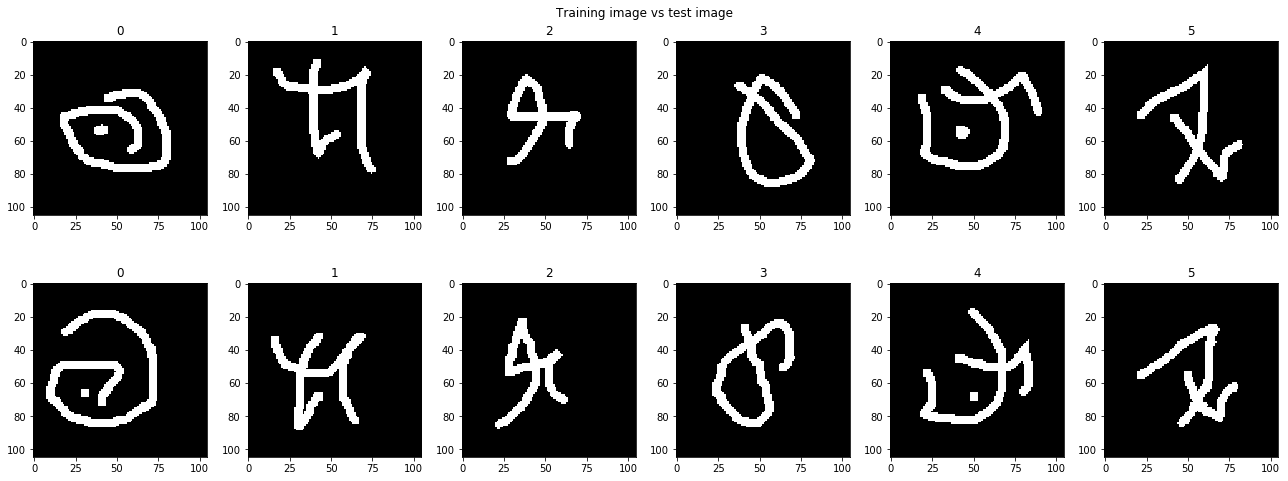

In [3]:
fig, ax = plt.subplots(2, 6, figsize=(18, 7))
test_y_sorted = np.argsort(run1.test_y)
for i in range(0, 6):
    ax[0, i].set_title(str(run1.train_y[i]))
    ax[0, i].imshow(run1.train_X[i].reshape(105, 105), cmap='gray')
    
    ax[1, i].set_title(str(run1.train_y[i]))
    ax[1, i].imshow(run1.test_X[test_y_sorted[i]].reshape(105, 105), cmap='gray')

    plt.tight_layout()
plt.suptitle("Training image vs test image")
plt.show()

###### Expanding images
In an attempt to combat images drawn off center I'll just remove all the empty space surrounding the characters, which I'll visualize below. Obviously this isn't perfect, and we'll need to perform more data augmentation later, but this will hopefully improve results somewhat.

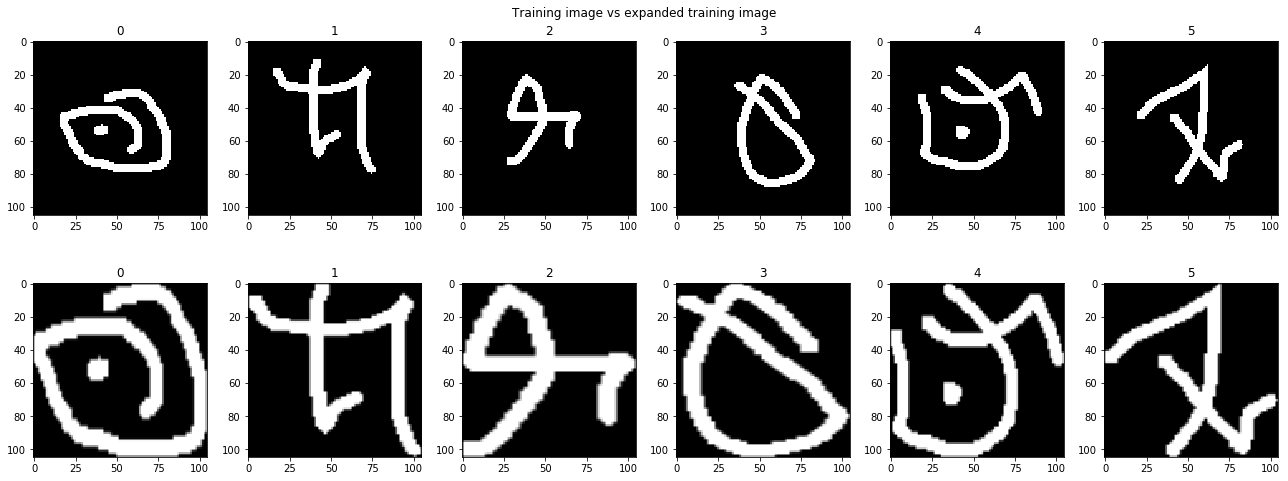

In [49]:
fig, ax = plt.subplots(2, 6, figsize=(18, 7))
test_y_sorted = np.argsort(run1.test_y)
for i in range(0, 6):
    ax[0, i].set_title(str(run1.train_y[i]))
    ax[0, i].imshow(run1.train_X[i].reshape(105, 105), cmap='gray')
    
    ax[1, i].set_title(str(run1.train_y[i]))
    ax[1, i].imshow(run1.train_X_expanded[i].reshape(105, 105), cmap='gray')

    plt.tight_layout()
plt.suptitle("Training image vs expanded training image")
plt.show()

## Nearest neighbor
I can't explore several nearest neighbors because there's only one training example (that we should match). What this means is we'll predict the class of an image by comparing it to each image in our training set and predict the class of the image it is most similar to.  
The challenge here is deciding out how to calculate the distance (or difference) between two images. I'll be calculating the mean squared error between each image and selecting the image with the lowest MSE as our solution.  
Brendan Lake provides a [small demo](https://github.com/brendenlake/omniglot/blob/master/python/one-shot-classification/demo_classification.py) using Hausdorff distance as a metric. I'll be comparing his results to mine.  
  
I'll first predict only on run1, and then score using all the runs.

In [5]:
from nearest_neighbor.nn_predict import nn_evaluate

run1_pred_mse = nn_evaluate(run1.train_X_expanded, run1.test_X_expanded, metric="mse")
run1_pred_haus = nn_evaluate(run1.train_X, run1.test_X, metric="hausdorff")

run1_acc_mse = score(run1_pred_mse, run1.test_y)
run1_acc_haus = score(run1_pred_haus, run1.test_y)

print(run1_acc_mse)
print(run1_acc_haus)

0.65
0.55


Neither technique is a home-run. In this case MSE predicted 10% better, we'll see if that persists through the 20 runs. Before that I'll visualize our predictions.

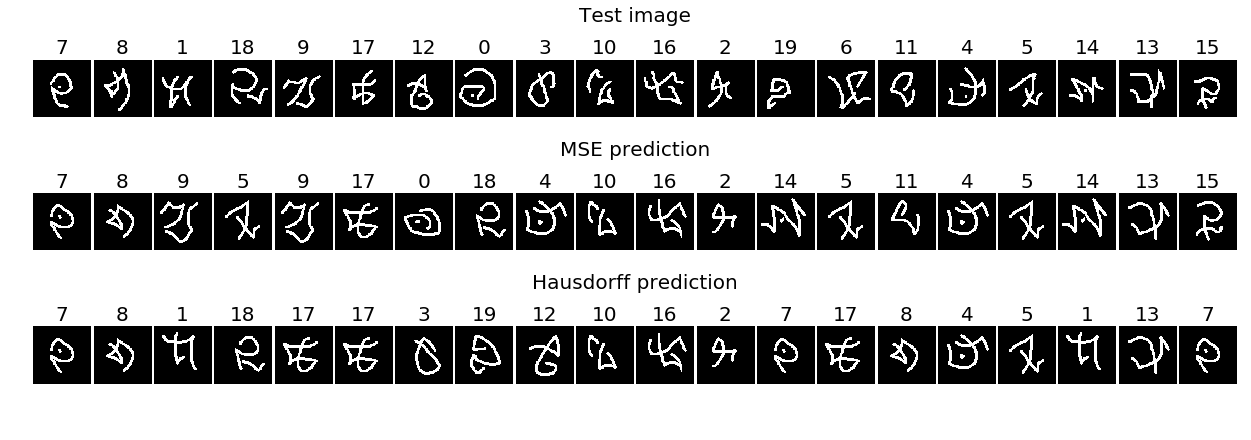

In [23]:
fig, big_axes = plt.subplots( figsize=(18, 6) , nrows=3, ncols=1, sharey=True)
titles = ["Test image", "MSE prediction", "Hausdorff prediction"]

for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title(titles[row-1], fontsize=20)
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    big_ax._frameon = False
    
def plot_row(imgs, it, order, titles, n_row, n_col, fig):
    for i in it:
        ax = fig.add_subplot(n_row,n_col,i)
        ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        ax._frameon = False
        ax.imshow(imgs[order[i-it[0]]].reshape(105, 105), cmap='gray')
        ax.set_title(str(titles[i-it[0]]), fontsize=20)

plot_row(run1.test_X, range(1, 21), range(0, 20), run1.test_y, 3, 20, fig)
plot_row(run1.train_X, range(21, 41), run1_pred_mse, run1_pred_mse, 3, 20, fig)
plot_row(run1.train_X, range(41, 61), run1_pred_haus, run1_pred_haus, 3, 20, fig)

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.show()

Interestingly using Hausdorff distance as our metric we predict correctly in several instances where MSE predicts incorrectly and vice versa. It I wanted to further explore nn as a solution I might want to look into combining the metrics.  
  
Now I'll be evaluating and scoring our full dataset (20 instances of 20 way 1 shot classification).

In [27]:
preds_mse = []
preds_haus = []
scores_mse = []
scores_haus = []

for run in all_runs:
    pred_mse = nn_evaluate(run.train_X_expanded, run.test_X_expanded, metric="mse")
    pred_haus = nn_evaluate(run.train_X, run.test_X, metric="hausdorff")
    
    preds_mse.append(pred_mse)
    preds_haus.append(pred_haus)
    
    scores_mse.append(score(pred_mse, run.test_y))
    scores_haus.append(score(pred_haus, run.test_y))
    
print("MSE mean score:", sum(scores_mse)/len(scores_mse)*100)
print("Hausdorff mean score:", sum(scores_haus)/len(scores_haus)*100)

MSE mean score: 58.25
Hausdorff mean score: 61.25


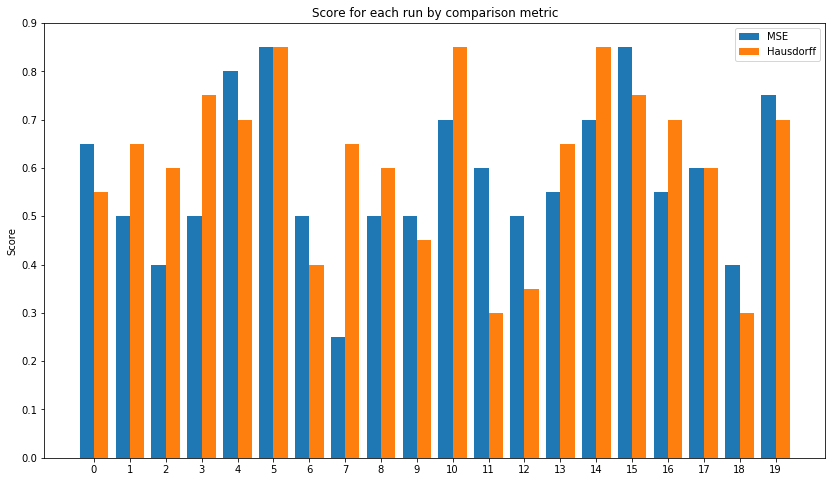

In [36]:
plt.figure(figsize = (14, 8))
N = len(scores_mse)
ind = np.arange(N)    
width = 0.4      

p1 = plt.bar(ind-0.2, scores_mse, width)
p2 = plt.bar(ind+0.2, scores_haus, width)

plt.ylabel('Score')
plt.title('Score for each run by comparison metric')
plt.xticks(ind, np.array(range(N), dtype=str))
plt.yticks(np.arange(0, 10, 1)/10.0)
plt.legend((p1[0], p2[0]), ('MSE', 'Hausdorff'))

plt.show()

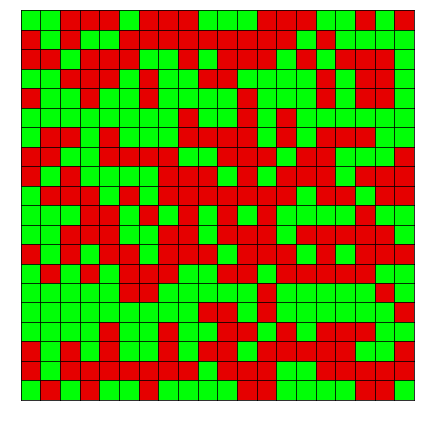

In [47]:
fig, ax = plt.subplots(figsize=(6, 6) , nrows=20, ncols=20)

for i in range(0, 20):
    for j in range(0, 20):
        ax[i, j].tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        if preds_mse[i][j] == preds_haus[i][j]:
            ax[i, j].set_facecolor('xkcd:bright green')
        else:
            ax[i, j].set_facecolor('xkcd:red')
        
        
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Simple convolutional neural network
There are many issues that come with using a CNN to solve this problem. For starters we're going to have to retrain the CNN for each dataset which will be tough on my CPU. In addition, the CNN will overfit because of our lack of data. Despite this I'll explore CNNs as a solution because they are a classical algorithm in image classification.  

I can try to combat the training time issue by reusing weights. I'll additionally be downsizing the image from 105x105 pixels to 34x34 pixels which will significantly reduce the number of floating point operations needed per convolution. I wouldn't necessarily do this if I wasn't training the CNN on my own machine.  
  
As with the nearest neighbor classifier I'll begin by testing my model on just the first dataset.

In [3]:
#Keras imports
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator

#### CNN model
Here I'll build the model. This model is rather small.  
TODO - visual of the network architecture?

In [4]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(10, 10),
                 activation='relu',
                 input_shape=(105, 105, 1)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, (7, 7), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(20, activation='softmax'))

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 64)        6464      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 64)        200768    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 28224)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3612800   
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2580      
Total para

###### Data augmentation/generator, optimizer.

In [6]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

batch_size = 64
epochs = 5

In [7]:
datagen = ImageDataGenerator(
        rotation_range=20,  
        zoom_range = 0.2,
        width_shift_range=0.2,
        height_shift_range=0.2)

In [8]:
datagen.fit(run1.train_X)
history = model.fit_generator(datagen.flow(run1.train_X,run1.train_y_cat, batch_size=batch_size),
                             epochs = epochs, validation_data = (run1.test_X,run1.test_y_cat),
                             verbose = 1, steps_per_epoch=25)

Epoch 1/5
25/25 [==============================] - 46s 2s/step - loss: 2.8731 - acc: 0.1360 - val_loss: 2.8224 - val_acc: 0.1000
Epoch 2/5
25/25 [==============================] - 49s 2s/step - loss: 2.6180 - acc: 0.2620 - val_loss: 2.4362 - val_acc: 0.2000
Epoch 3/5
25/25 [==============================] - 45s 2s/step - loss: 2.1971 - acc: 0.3780 - val_loss: 1.7331 - val_acc: 0.4500
Epoch 4/5
25/25 [==============================] - 53s 2s/step - loss: 1.6322 - acc: 0.5400 - val_loss: 1.4649 - val_acc: 0.6000
Epoch 5/5
25/25 [==============================] - 46s 2s/step - loss: 1.1125 - acc: 0.6700 - val_loss: 1.3323 - val_acc: 0.5500


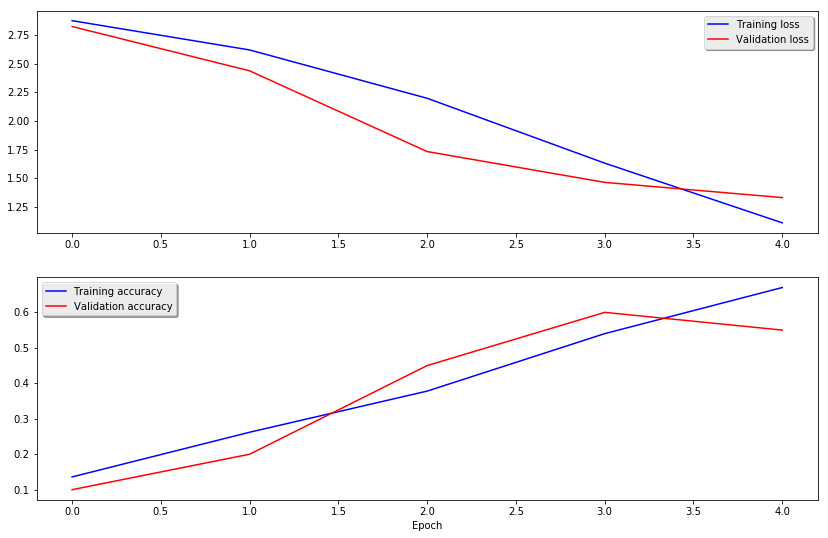

In [9]:
fig, ax = plt.subplots(2,1, figsize=(14, 9))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].set_xlabel("Epoch")
legend = ax[1].legend(loc='best', shadow=True)

Looks like we were on the verge of overfitting. Now I'll train and test this model on all of our datasets.  
Because we have a pretrained model I'll only train for 3 epochs and see where that gets us.

In [10]:
histories = []

for run in all_runs:
    print("=", end="") #makeshift progress bar
    datagen.fit(run.train_X)
    history = model.fit_generator(datagen.flow(run.train_X,run.train_y_cat, batch_size=batch_size),
                                 epochs = 3, validation_data = (run.test_X,run.test_y_cat),
                                 verbose = 0, steps_per_epoch=25)
    histories.append(history)

In [39]:
avg_acc = sum([hist.history['val_acc'][-1] for hist in histories]) / len(histories) * 100
print("CNN mean score:", avg_acc)

CNN mean score: 59.5000007749


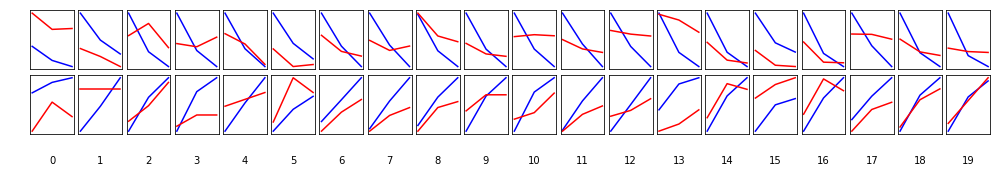

In [37]:
fig, ax = plt.subplots(2,20, figsize=(14, 2.5))
for i, history in enumerate(histories):
    ax[0][i].tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    ax[1][i].tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')

    ax[0][i].plot(history.history['loss'], color='b', label="Training")
    ax[0][i].plot(history.history['val_loss'], color='r', label="Validation")

    ax[1][i].plot(history.history['acc'], color='b', label="Training")
    ax[1][i].plot(history.history['val_acc'], color='r',label="Validation")
    ax[1][i].set_xlabel(str(i))

plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

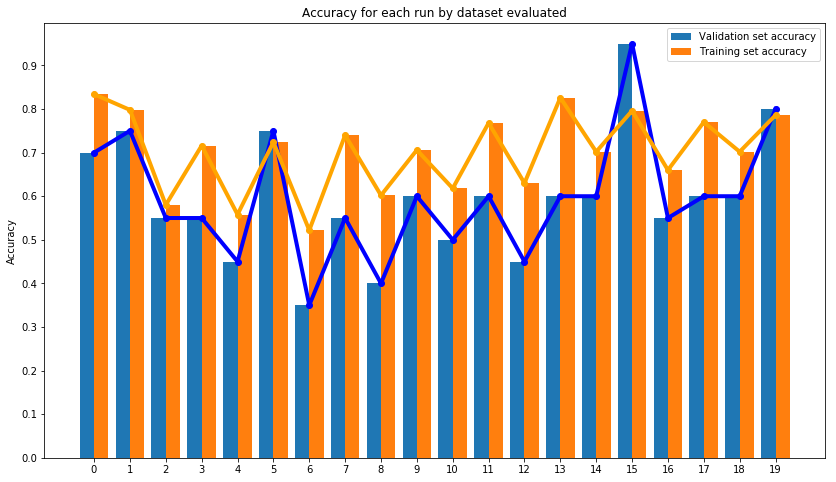

In [48]:
plt.figure(figsize = (14, 8))
N = len(histories)
ind = np.arange(N)    
width = 0.4      

val_acc = [history.history['val_acc'][-1] for history in histories]
train_acc = [history.history['acc'][-1] for history in histories]

p1 = plt.bar(ind-0.2, val_acc, width)
p2 = plt.bar(ind+0.2, train_acc, width)

plt.plot(val_acc, color='blue', linewidth=4, marker="o")
plt.plot(train_acc, color='orange', linewidth=4, marker="o")

plt.ylabel('Accuracy')
plt.title('Accuracy for each run by dataset evaluated')
plt.xticks(ind, np.array(range(N), dtype=str))
plt.yticks(np.arange(0, 10, 1)/10.0)
plt.legend((p1[0], p2[0]), ('Validation set accuracy', 'Training set accuracy'))

plt.show()

## Gaussian prototypical network
